# Building a fastText word vector based siamese LSTM model for computing comprehension scores for pairs of text

### 1. Import the libraries

In [14]:
# This Source Code Form is subject to the terms of the MPL
# License. If a copy of the same was not distributed with this
# file, You can obtain one at
# https://github.com/akhilpandey95/pubundsci/blob/master/LICENSE.

import os
import random
import string
import spacy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

### 2. Load the data

#### 2.1 Load the fastText word vector

In [4]:
# load the fastText word embedding
nlp = sp.load('pubundsci_ft_wvec')

#### 2.2 Read the semeval training data and prepare the training dataset

In [5]:

# load semeval dataset
semeval_train_data = pd.read_csv('paragraph2sentence.train.input.tsv', sep='\t')
semeval_train_vals = pd.read_csv('paragraph2sentence.train.gs.tsv', sep='\t')

# create a defaultdict
train_data = defaultdict(dict)

# add the column containing the paragraphs
train_data['text_a'] = [semeval_train_data.columns[0] if x == 0 
                  else semeval_train_data[semeval_train_data.columns[0]][x] 
                  for x in range(len(semeval_train_data[semeval_train_data.columns[0]]))]

# add the column containing the sentences
train_data['text_b'] = [semeval_train_data.columns[1] if x == 0
                  else semeval_train_data[semeval_train_data.columns[1]][x]
                  for x in range(len(semeval_train_data[semeval_train_data.columns[1]]))]

# add the column containing the categories
train_data['cat'] = [semeval_train_data.columns[2] if x == 0
                  else semeval_train_data[semeval_train_data.columns[2]][x]
                  for x in range(len(semeval_train_data[semeval_train_data.columns[2]]))]

# add the column containing the similarity scores
train_data['sim_score'] = [semeval_train_vals.columns[0] if x == 0
                  else semeval_train_vals[semeval_train_vals.columns[0]][x]
                  for x in range(len(semeval_train_vals[semeval_train_vals.columns[0]]))]

# convert the dict to a dataframe
train_data = pd.DataFrame(train_data)

# print the head of the data
train_data.head()

,text_a,text_b,cat,sim_score
0,"Little St-Julien-le-Pauvre, a jewel of early G...",Bricks fired on the spot are the valley’s main...,Travel-1,0.00
1,Manzanillo initially drew the interest of inte...,"Nearby, on Calle Pío Rosado, the Museo Emilio ...",Travel-3,0
2,Alongside a landmark water tower is a good ope...,"Following a Mongol invasion, King Belá IV made...",Travel-4,2.5
3,Most beaches protected from the open ocean hav...,Boat cruises offer a care free way to enjoy th...,Travel-5,3
4,Shaolin offers one more treat for the more adv...,Visitors may ride a gondola to the mountain to...,Travel-6,2.5


#### 2.3 Normalize the sim_score column in the training data to a 0-1 range

In [6]:
# store the values of the scores into an array
x = train_data['sim_score'].values.astype(float)

# reshape the array
x = x.reshape(-1, 1)

# create a minmax processor object
min_max_scaler = MinMaxScaler()

# create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
train_data = train_data.assign(sim_score = x_scaled)

# print the head of the data
train_data.head()

,text_a,text_b,cat,sim_score
0,"Little St-Julien-le-Pauvre, a jewel of early G...",Bricks fired on the spot are the valley’s main...,Travel-1,0.000
1,Manzanillo initially drew the interest of inte...,"Nearby, on Calle Pío Rosado, the Museo Emilio ...",Travel-3,0.000
2,Alongside a landmark water tower is a good ope...,"Following a Mongol invasion, King Belá IV made...",Travel-4,0.625
3,Most beaches protected from the open ocean hav...,Boat cruises offer a care free way to enjoy th...,Travel-5,0.750
4,Shaolin offers one more treat for the more adv...,Visitors may ride a gondola to the mountain to...,Travel-6,0.625


#### 2.4 Read the semeval test data and prepare the test dataset

In [7]:

# load semeval dataset
semeval_test_data = pd.read_csv('paragraph2sentence.test.input.tsv', sep='\t')
semeval_test_vals = pd.read_csv('paragraph2sentence.test.gs.tsv', sep='\t')

# create a defaultdict
test_data = defaultdict(dict)

# add the column containing the paragraphs
test_data['text_a'] = [semeval_test_data.columns[0] if x == 0 
                  else semeval_test_data[semeval_test_data.columns[0]][x] 
                  for x in range(len(semeval_test_data[semeval_test_data.columns[0]]))]

# add the column containing the sentences
test_data['text_b'] = [semeval_test_data.columns[1] if x == 0
                  else semeval_test_data[semeval_test_data.columns[1]][x]
                  for x in range(len(semeval_test_data[semeval_test_data.columns[1]]))]

# add the column containing the categories
test_data['cat'] = [semeval_test_data.columns[2] if x == 0
                  else semeval_test_data[semeval_test_data.columns[2]][x]
                  for x in range(len(semeval_test_data[semeval_test_data.columns[2]]))]

# add the column containing the similarity scores
test_data['sim_score'] = [semeval_test_vals.columns[0] if x == 0
                  else semeval_test_vals[semeval_test_vals.columns[0]][x]
                  for x in range(len(semeval_test_vals[semeval_test_vals.columns[0]]))]

# convert the dict to a dataframe
test_data = pd.DataFrame(test_data)

# print the head of the data
test_data.head()

,text_a,text_b,cat,sim_score
0,Well what I want to know is that is it possibl...,I have heard that Verizon has the fastest spee...,CQA-1,1.25
1,"On a certain site, my friend was using my comp...",If I have set a website to never remember my p...,CQA-3,4
2,"OKay, so i am interested in blogging, although...",how do you know if your twitter account is bei...,CQA-4,0
3,The donations page for a legit church site tha...,How can i get rid of an image on imageshack wi...,CQA-5,0
4,I'm not looking to get rich or anything. I jus...,Online scams have been known to be very danger...,CQA-6,0.5


#### 2.5 Normalize the sim_score column in the test data to a 0-1 range

In [8]:
# store the values of the scores into an array
x = test_data['sim_score'].values.astype(float)

# reshape the array
x = x.reshape(-1, 1)

# create a minmax processor object
min_max_scaler = MinMaxScaler()

# create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
test_data = test_data.assign(sim_score = x_scaled)

# print the head of the data
test_data.head()

,text_a,text_b,cat,sim_score
0,Well what I want to know is that is it possibl...,I have heard that Verizon has the fastest spee...,CQA-1,0.3125
1,"On a certain site, my friend was using my comp...",If I have set a website to never remember my p...,CQA-3,1.0000
2,"OKay, so i am interested in blogging, although...",how do you know if your twitter account is bei...,CQA-4,0.0000
3,The donations page for a legit church site tha...,How can i get rid of an image on imageshack wi...,CQA-5,0.0000
4,I'm not looking to get rich or anything. I jus...,Online scams have been known to be very danger...,CQA-6,0.1250


### 3. Create a `tf` session and set model params 

In [ ]:
# init a tf session
sess = tf.Session()

# model parameters
batch_size = 200
num_batches = 300
max_address_len = 20
margin = 0.20
num_features = 50
dropout_keep_prob = 0.8

### 4. The Siamese LSTM model

#### 4.1 Class definition for the Sia_lstm model

In [12]:
# @param_1 : pair_one
# @param_2 : pair_two
# @param_3 : dropout_keep_prob
# @param_4 : vocab_size
# @param_5 : num_features
# @param_6 : length
class siamese_lstm(object):
    # call the init function
    def __init__(self, config):
        # tf placeholders for input, output and dropout variables
        self.input_text_left = tf.placeholder(tf.int32, [None, config.seq_len], name='input_text_left')
        self.input_text_right = tf.placeholder(tf.int32, [None, config.seq_len], name='input_text_right')
        self.input_sim_score = tf.placeholder(tf.float32, [None], name='input_sim_score')
        self.dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')
        
        # tf constant for l2 regularization loss
        l2_reg_loss = tf.constant(0.0, name='l2_reg_loss')
        
        # using fastText embedding Embedding layer
        with tf.name_scope('ft_word_embedding'):
            # variables for the embedding layer
            self.word = tf.Variable(
                tf.constant(0.0, shape=[config.vocab_size, config.embedding_size]),
                trainable=config.train_embeddings, name='word')
            self.emb_words_left = tf.nn.embedding_lookup(self.word, self.input_text_left)
            self.emb_words_right = tf.nn.embedding_lookup(self.word, self.input_text_right)
            
        # using a conv maxpool layer
        with tf.name_scope('output'):
            

#### 4.3. Helper functions for the LSTM model

In [9]:
# function for loading vectors from a .vec file
def load_vec(file):
    # create an empty dict
    res = {}
    
    # open the file
    f = io.open(file, encoding='utf-8', newline='\n', errors='ignore')
    
    # map a integer over all the words
    n, d = map(int, f.readline().split())
    
    # look for tokens
    for line in f:
        tokens = line.rstrip().split(' ')
        res[tokens[0]] = map(float, tokens[1:])
    
    # return the vector representation
    return res

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [35]:
train_data.to_csv("train_data.csv", sep = ',', encoding="utf-8")

In [36]:
test_data.to_csv("test_data.csv", sep = ',', encoding="utf-8")

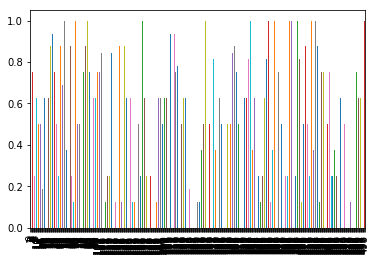

In [38]:
train_data['sim_score'].plot(kind='bar')0